# リポジトリクローン

In [1]:
!git clone https://github.com/apple/ml-fastvlm
%cd ml-fastvlm

Cloning into 'ml-fastvlm'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 112 (delta 2), reused 0 (delta 0), pack-reused 99 (from 1)
Receiving objects: 100% (112/112), 10.71 MiB | 37.04 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/ml-fastvlm


# パッケージインストール

In [2]:
!pip install -q transformers==4.49.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.5 MB/s eta 0:00:00


# 重みダウンロード

In [ ]:
%%bash

mkdir -p checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_0.5b_stage2.zip -P checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_0.5b_stage3.zip -P checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_1.5b_stage2.zip -P checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_1.5b_stage3.zip -P checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_7b_stage2.zip -P checkpoints
wget https://ml-site.cdn-apple.com/datasets/fastvlm/llava-fastvithd_7b_stage3.zip -P checkpoints

cd checkpoints
unzip -qq llava-fastvithd_0.5b_stage2.zip
unzip -qq llava-fastvithd_0.5b_stage3.zip
unzip -qq llava-fastvithd_1.5b_stage2.zip
unzip -qq llava-fastvithd_1.5b_stage3.zip
unzip -qq llava-fastvithd_7b_stage2.zip
unzip -qq llava-fastvithd_7b_stage3.zip

rm llava-fastvithd_0.5b_stage2.zip
rm llava-fastvithd_0.5b_stage3.zip
rm llava-fastvithd_1.5b_stage2.zip
rm llava-fastvithd_1.5b_stage3.zip
rm llava-fastvithd_7b_stage2.zip
rm llava-fastvithd_7b_stage3.zip
cd -

# サンプル画像ダウンロード

In [4]:
# https://www.pakutaso.com/20171115305post-13899.html
!wget https://user0514.cdnw.net/shared/img/thumb/kawamura1030IMGL3937_TP_V4.jpg -O sample.jpg

--2025-07-01 14:16:53--  https://user0514.cdnw.net/shared/img/thumb/kawamura1030IMGL3937_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.105.216.58
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.105.216.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82319 (80K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  80.39K   374KB/s    in 0.2s    

2025-07-01 14:16:54 (374 KB/s) - ‘sample.jpg’ saved [82319/82319]



# 実行パラメータ

In [25]:
# モデル指定
checkpoint_dir_path = "checkpoints/llava-fastvithd_0.5b_stage2"
# checkpoint_dir_path = "checkpoints/llava-fastvithd_0.5b_stage3"
# checkpoint_dir_path = "checkpoints/llava-fastvithd_1.5b_stage2"
# checkpoint_dir_path = "checkpoints/llava-fastvithd_1.5b_stage3"
# checkpoint_dir_path = "checkpoints/llava-fastvithd_7b_stage2"
# checkpoint_dir_path = "checkpoints/llava-fastvithd_7b_stage3"

In [45]:
# プロンプト
prompt = "Describe the image."
# prompt = "Describe the image briefly."
image_path = "sample.jpg"

In [46]:
# 他パラメータ
model_base = None
conv_mode = "qwen_2"
temperature = 0.2
top_p = None
num_beams = 1

# モデル読み込み

In [47]:
import os
import torch
from llava.utils import disable_torch_init
from llava.mm_utils import get_model_name_from_path
from llava.model.builder import load_pretrained_model

# チェックポイントのパスをホームディレクトリベースで展開
checkpoint_dir_path = os.path.expanduser(checkpoint_dir_path)

# generation_config.json が存在するかチェックし、一時的にリネームして退避
generation_config = None
if os.path.exists(os.path.join(checkpoint_dir_path, 'generation_config.json')):
    generation_config = os.path.join(checkpoint_dir_path, '.generation_config.json')
    os.rename(os.path.join(checkpoint_dir_path, 'generation_config.json'),
              generation_config)

# PyTorchの重みの初期化を無効化（再現性や速度向上のため）
disable_torch_init()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # macOSでのGPUバックエンドの場合は"mps"
print(device)

# モデル読み込み
model_name = get_model_name_from_path(checkpoint_dir_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(checkpoint_dir_path, model_base, model_name, device=device)

cuda


# プロンプト構築

In [48]:
from PIL import Image
from llava.conversation import conv_templates
from llava.mm_utils import tokenizer_image_token, process_images
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN

# プロンプトを構築
qs = prompt
if model.config.mm_use_im_start_end:
    # モデルが画像の開始・終了トークンを必要とする場合、それらを挿入
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    # 通常は <image> トークンだけを挿入
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

# 会話テンプレートを複製して、プロンプトと応答の枠を設定
conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)    # ユーザーの発言
conv.append_message(conv.roles[1], None)  # モデルの応答（空）
prompt = conv.get_prompt()

In [49]:
# モデルの生成設定にパディングトークンIDを指定
model.generation_config.pad_token_id = tokenizer.pad_token_id

# プロンプトをトークナイズし、バッチ次元を追加してデバイスへ転送
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(torch.device(device))

# 画像を読み込み、RGBに変換して前処理
image = Image.open(image_path).convert('RGB')
image_tensor = process_images([image], image_processor, model.config)[0]  # [3, H, W] のテンソル

In [50]:
%%time

# 推論
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor.unsqueeze(0).half(),
        image_sizes=[image.size],
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=256,
        use_cache=True,
    )

CPU times: user 7.45 s, sys: 22.1 ms, total: 7.47 s
Wall time: 7.46 s


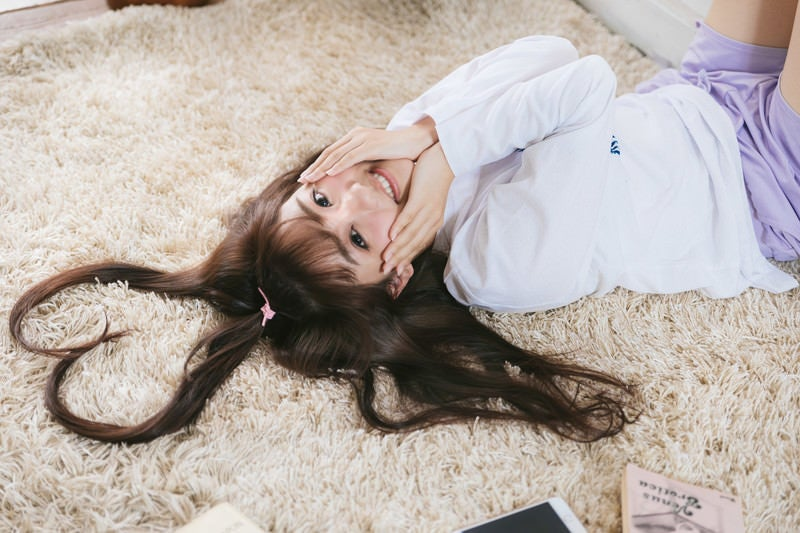

In [51]:
image

In [52]:
# 結果表示
outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(outputs)

The image depicts a young girl lying on a beige shaggy rug. She is wearing a white long-sleeved shirt and purple pants. Her hair is long and dark, with a pink hair tie visible in her hair. She is smiling and appears to be in a relaxed, playful pose, with her hands gently resting on her face. Her eyes are open and she seems to be looking directly at the camera.

In the foreground, there are a few objects scattered on the rug. There is a small, rectangular, black object that appears to be a book or a notebook. Next to it, there is a white rectangular object that could be a box or a small container. The background is relatively simple, featuring a plain beige wall and a portion of a white door frame.

The overall atmosphere of the image is casual and homely, suggesting a comfortable, relaxed environment. The girl's playful pose and smile indicate that she is enjoying her time on the rug, possibly engaging in a playful activity or simply having fun.

### Analysis and Description

1. **Subj

In [13]:
# # generation_config.json を元に戻す
# if generation_config is not None:
#     os.rename(generation_config, os.path.join(checkpoint_dir_path, 'generation_config.json'))